###### Inicialização

In [41]:
!pip install meteostat yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import numpy as np
import pandas as pd
from datetime import datetime, date
from IPython.display import Markdown
from itertools import product

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots as tsa

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)

from meteostat import Point, Daily

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

import seaborn as sns
import plotly.graph_objects as go

In [43]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["figure.figsize"] = (22,6)

In [44]:
def resultado_adf(resultado, alpha = .05):
  adf, pvalue, usedlag, nobs, critical = resultado[0:5]
  
  display(Markdown('Statistics=%.3f, p-valor=%.8f' % (adf, pvalue)))
  # interpretando resultados
  if pvalue > alpha:
      display(Markdown("**A série não é estacionária (falhamos em rejeitar H0)**"))
  else:
      display(Markdown('**A série é estacionária (rejeitamos H0)**'))

Captura dos dados de temperatura

In [45]:
start = datetime(2018, 1, 1)
end = datetime(2022, 10, 31)

location = Point(-11.0056387, -37.2432436) #Aracaju

aracaju = Daily(location, start, end)
serie_aracaju = aracaju.fetch()

serie_aracaju.tavg.fillna(serie_aracaju.tavg.mean(),inplace=True)

# Análise de Séries temporais (Sessão 13)
---
Modelando Séries (parte 4)

## Modelo SARIMA

Dado que o modelo ARIMA imcorpora a tendência determinística, o modelo SARIMA incorpora a **tendência determinística e os efeitos sazonais** da série temporal.

Recapitulando modelo ARIMA:

\begin{align}
ARIMA(p,q) &= X_t= α_1X_{t-1} + ... + α_pX_{t-p} + ε_t + β_1ε_{t-1} + ... + β_qε_{t-q} \\
ARIMA(p,q) &= X_t = \sum_{h=1}^p{\alpha_hx_{t-h}} + \sum_{h=1}^q{\beta_hε_{t-h}} + ε_t 
\end{align}

Este modelo é muito semelhante ao modelo ARIMA, exceto que há um conjunto adicional de componentes autorregressivos e de média móvel. Os atrasos adicionais são compensados ​​pela frequência da sazonalidade (ex. 12 — mensal, 24 — horária).

Assim, evoluimos o modelo ARIMA para capturar os componentes sazonais:

\begin{align}
SARIMA(p,q,P,Q) &= X_t = \sum_{h=1}^p{\alpha_hx_{t-h}} + \sum_{h=1}^q{\beta_hε_{t-h}} + \color{blue} {\sum_{h=1}^P{\phi_hx_{t-h}} + \sum_{h=1}^Q{\eta_hε_{t-h}}} + ε_t 
\end{align}

Os modelos SARIMA permitem diferenciar dados por frequência sazonal, mas também por diferenciação não sazonal.

Na prática, o SARIMA é descrito como $SARIMA(p,d,q)(P,D,Q)[m]$. Onde cada um dos hiperparâmetros é descrito por:

- P: Ordem Autorregressiva Sazonal
- D: Ordem da diferença sazonal
- Q: Ordem média móvel sazonal
- m: O número de intervalos de tempo para um único período sazonal.

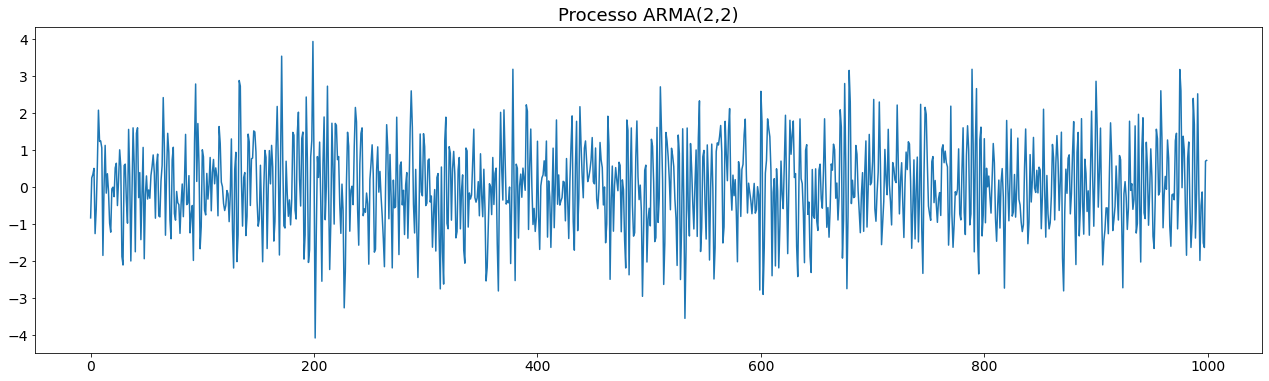

In [46]:
ar = np.array([1, .3 , .5])
ma = np.array([1, .7, .2])

serie_arma22 = sm.tsa.ArmaProcess(ar, ma).generate_sample(nsample=1000)
serie_arma22 = pd.Series(serie_arma22)

_ = serie_arma22.plot(title = "Processo ARMA(2,2)")

In [47]:
x = np.arange(1, 100 * np.pi, 0.1)
T = pd.Series(x/5)
S = pd.Series(np.sin(x)*4) + 2

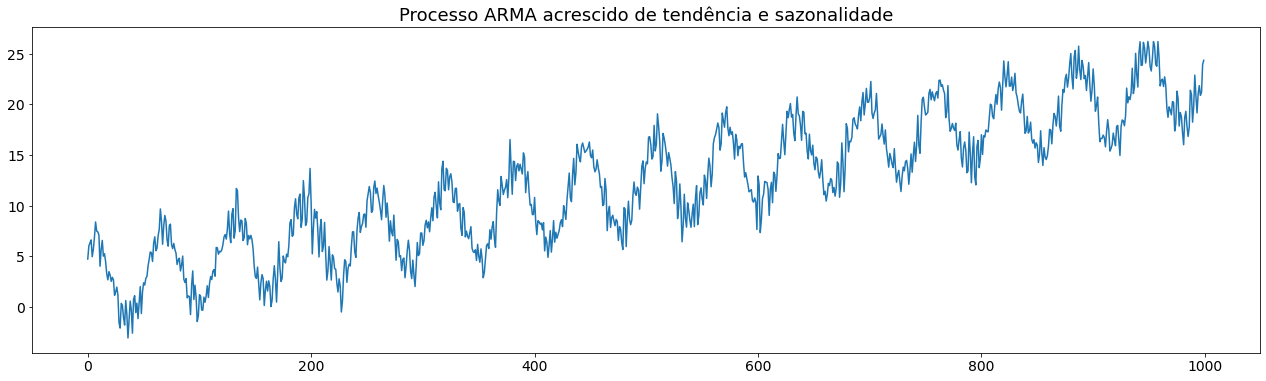

In [48]:
processo_sarima = (serie_arma22 + T + S).dropna()
_ = processo_sarima.plot(title="Processo ARMA acrescido de tendência e sazonalidade")

### Identificando o Modelo SARIMA

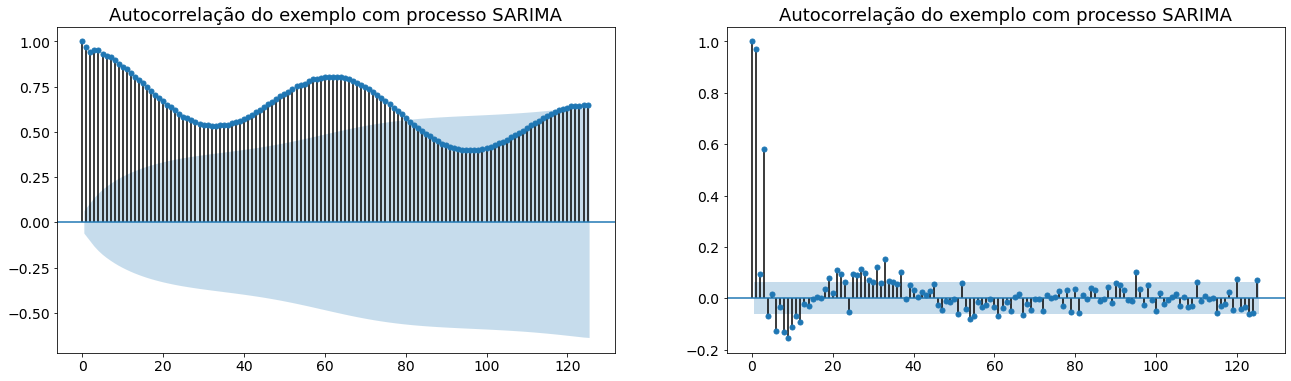

In [49]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(processo_sarima, lags= len(processo_sarima)/8, ax = axs[0], title="Autocorrelação do exemplo com processo SARIMA")
_ = tsa.plot_pacf(processo_sarima, lags= len(processo_sarima)/8, ax = axs[1], title="Autocorrelação do exemplo com processo SARIMA")

- Decaimento exponencial nas defasagens sazonais do ACF (lag 31, 62, 94, …)
- Um pico é observado no lag 31 no PACF

### Ajustamento

Ajustar a função SARIMA(p,d,q)(P,D,Q)[S], em que (p,d,q) são os parâmentros relacionados à decomposição de segunda ordem (tendência), (P,D,Q) são os parâmetros relacionados à decomposição de primeira ordem (efeito sazonal) e [S] é o período do efeito sazonal (ex. 12 meses).

In [50]:
resultado_adf(sm.tsa.adfuller(processo_sarima))

Statistics=-2.127, p-valor=0.23368656

**A série não é estacionária (falhamos em rejeitar H0)**

In [51]:
processo_sarima_dif = processo_sarima.diff().dropna()
resultado_adf(sm.tsa.adfuller(processo_sarima_dif))

Statistics=-9.054, p-valor=0.00000000

**A série é estacionária (rejeitamos H0)**

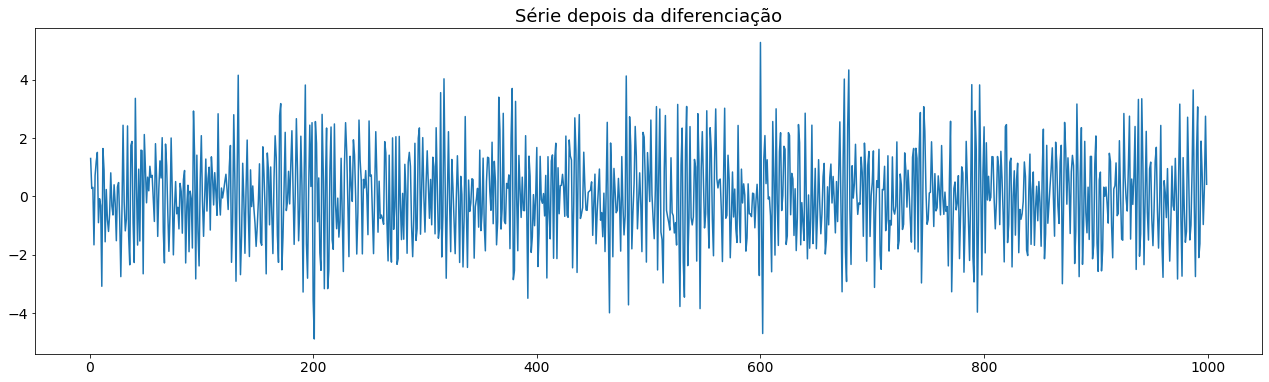

In [52]:
_ = processo_sarima_dif.plot(title="Série depois da diferenciação")

In [53]:
resultado_adf(sm.tsa.adfuller(processo_sarima_dif.diff(62).dropna()))

Statistics=-12.211, p-valor=0.00000000

**A série é estacionária (rejeitamos H0)**

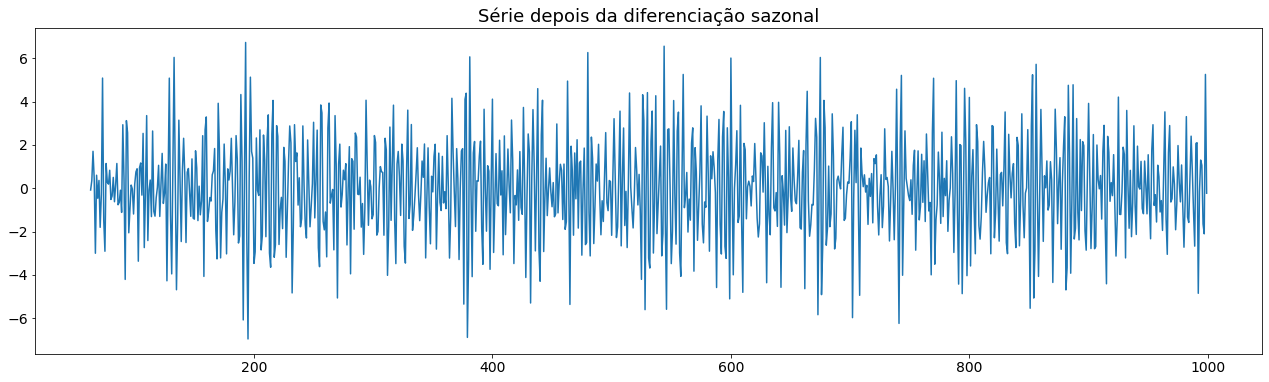

In [54]:
_ = processo_sarima_dif.diff(62).plot(title="Série depois da diferenciação sazonal")

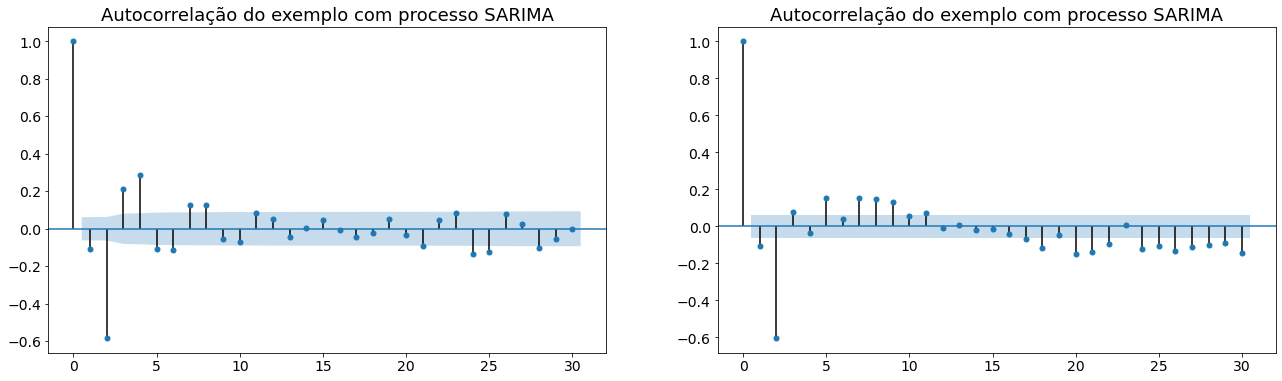

In [55]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(processo_sarima_dif, ax = axs[0], title="Autocorrelação do exemplo com processo SARIMA")
_ = tsa.plot_pacf(processo_sarima_dif, ax = axs[1], title="Autocorrelação do exemplo com processo SARIMA")

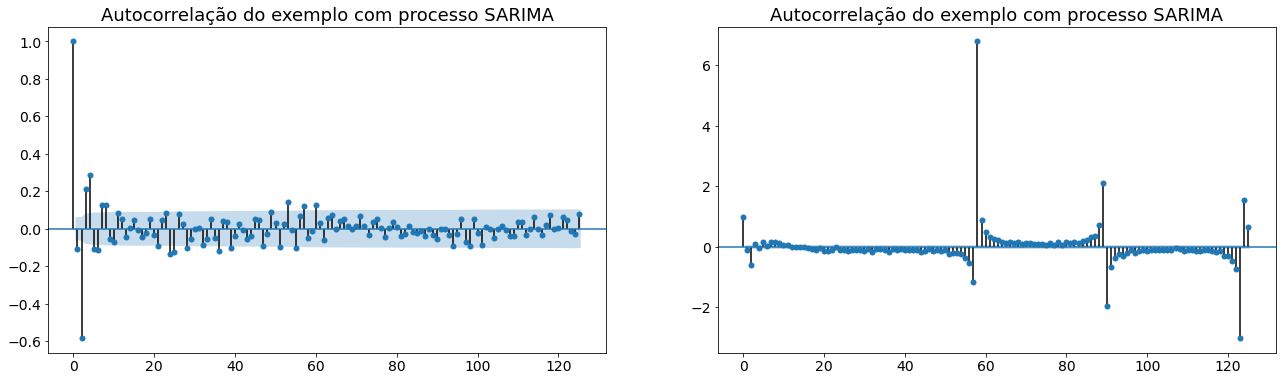

In [56]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(processo_sarima_dif, lags= len(processo_sarima)/8, ax = axs[0], title="Autocorrelação do exemplo com processo SARIMA")
_ = tsa.plot_pacf(processo_sarima_dif, lags= len(processo_sarima)/8, ax = axs[1], title="Autocorrelação do exemplo com processo SARIMA")

Usamos o ACF para determinar a dupla (q,Q) e o PACF para determinar a dupla (p,P). Neste exemplo vamos utilizar $p = 2, P = 1, q = 4, Q = 0$.

Como já sabemos que o efeito sazonal se repete a cada 62 eventos, utilizaremos $m = 62$.

Dicas:
1. Quando (p,q) e (P,Q) não são muito evidentes da ACF e PACF, ache-os num intervalo de [0,2], procurando uma combinação de parâmetros que minimize AIC.
2. Note que os parâmetros (P,Q) estão relacionados à correlação presente na ACF e na PACF no intervalo m, 2m, 3m, ... .

In [57]:
modelo_sarima = sm.tsa.SARIMAX(processo_sarima, order=(2,1,4), seasonal_order=(1,0,0,62)).fit()

In [58]:
print(modelo_sarima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1000
Model:             SARIMAX(2, 1, 4)x(1, 0, [], 62)   Log Likelihood               -1608.974
Date:                             Tue, 14 Feb 2023   AIC                           3233.949
Time:                                     02:36:30   BIC                           3273.203
Sample:                                          0   HQIC                          3248.869
                                            - 1000                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0301      0.209      0.144      0.885      -0.379       0.439
ar.L2          0.2331      

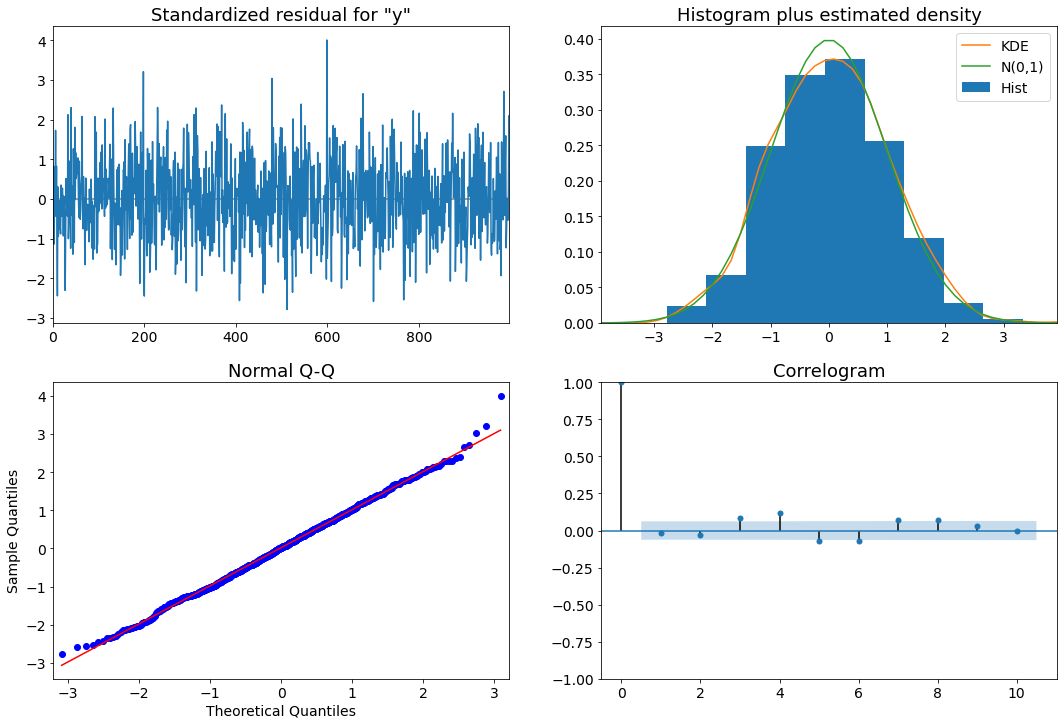

In [60]:
_ = modelo_sarima.plot_diagnostics(figsize=(18,12))

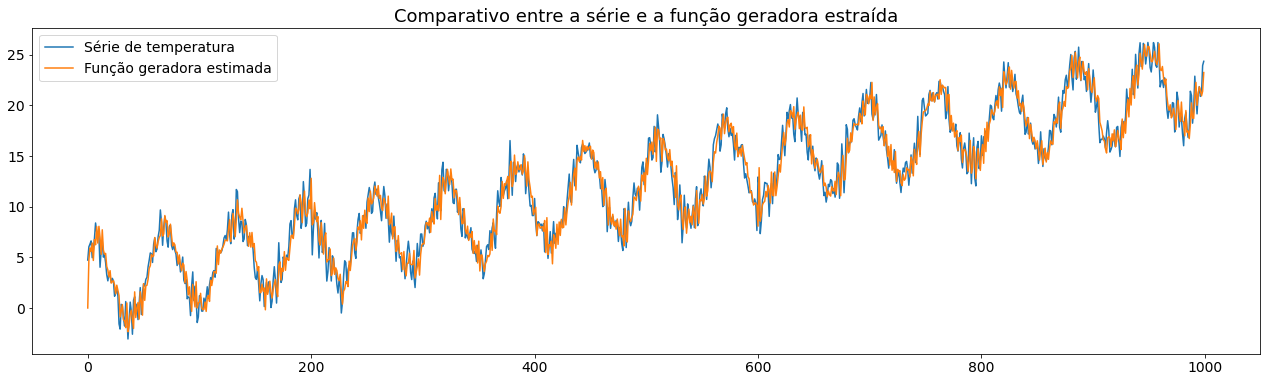

In [61]:
ax = processo_sarima.plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_sarima.fittedvalues.plot(ax = ax, label="Função geradora estimada", legend= True)

#### Auto SARIMA

In [62]:
def auto_SARIMA(experimentos, d, D, s, serie):
    resutados = []
    
    for experimento in tqdm(experimentos):
        try: 
            modelo = sm.tsa.SARIMAX(serie, order=(experimento[0], d, experimento[1]),
                                    seasonal_order=(experimento[2], D, experimento[3], s)).fit(disp=-1)
        except:
            continue
            
        resutados.append([experimento, modelo.aic])
        del modelo
        
    result_df = pd.DataFrame(resutados)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True) #ordenando pelo AIC
    
    return result_df

In [63]:
p = range(1, 4, 1)
d = 1
q = range(3, 6, 1)
P = range(0, 2, 1)
D = 0
Q = range(0, 1, 1)
s = 62

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [64]:
result_df = auto_SARIMA(parameters_list, d, D, s, processo_sarima)
result_df

  0%|          | 0/18 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(3, 4, 0, 0)",3062.224900
1,"(3, 5, 0, 0)",3165.470719
2,"(3, 5, 1, 0)",3167.093836
3,"(3, 3, 0, 0)",3175.193105
4,"(3, 3, 1, 0)",3176.872712
5,"(2, 5, 0, 0)",3197.997028
6,"(1, 5, 0, 0)",3202.684768
7,"(1, 5, 1, 0)",3204.491748
8,"(2, 5, 1, 0)",3226.315225
9,"(2, 3, 0, 0)",3228.309578


In [65]:
melhores = result_df.iloc[0,0]
modelo_autosarima = sm.tsa.SARIMAX(processo_sarima, order=(melhores[0], d, melhores[1]),
                                    seasonal_order=(melhores[2], D, melhores[3], s)).fit(disp=-1)

In [66]:
print(modelo_autosarima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(3, 1, 4)   Log Likelihood               -1523.112
Date:                Tue, 14 Feb 2023   AIC                           3062.225
Time:                        02:43:18   BIC                           3101.479
Sample:                             0   HQIC                          3077.145
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7056      0.044     38.453      0.000       1.619       1.793
ar.L2         -0.4438      0.088     -5.017      0.000      -0.617      -0.270
ar.L3         -0.2746      0.045     -6.160      0.0

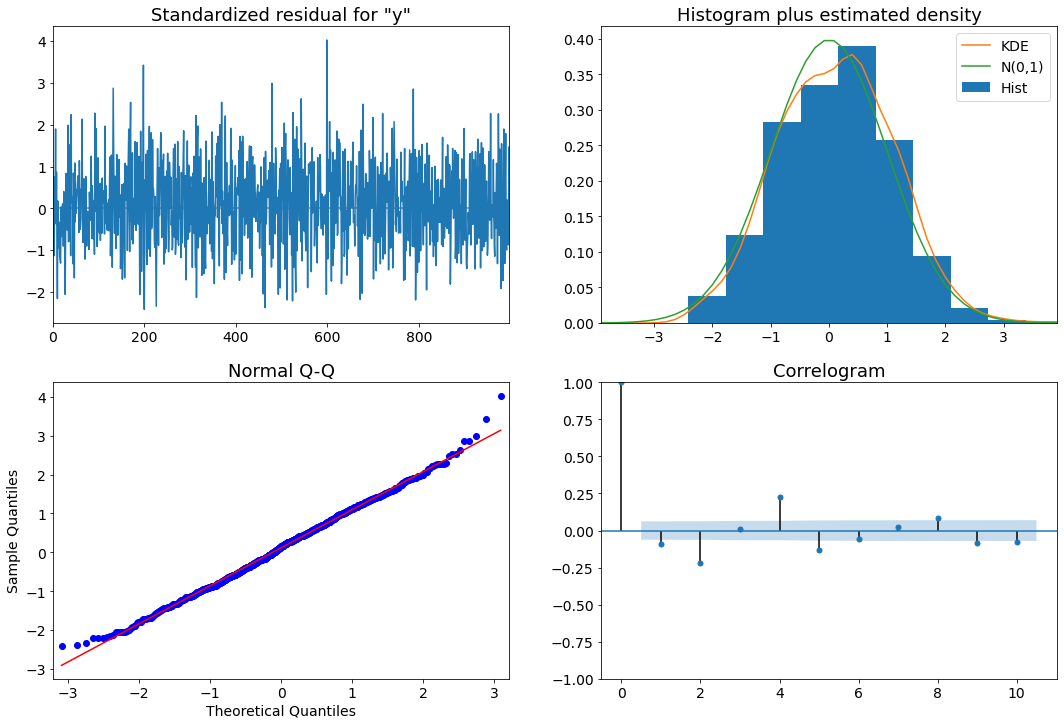

In [67]:
_ = modelo_autosarima.plot_diagnostics(figsize=(18,12))

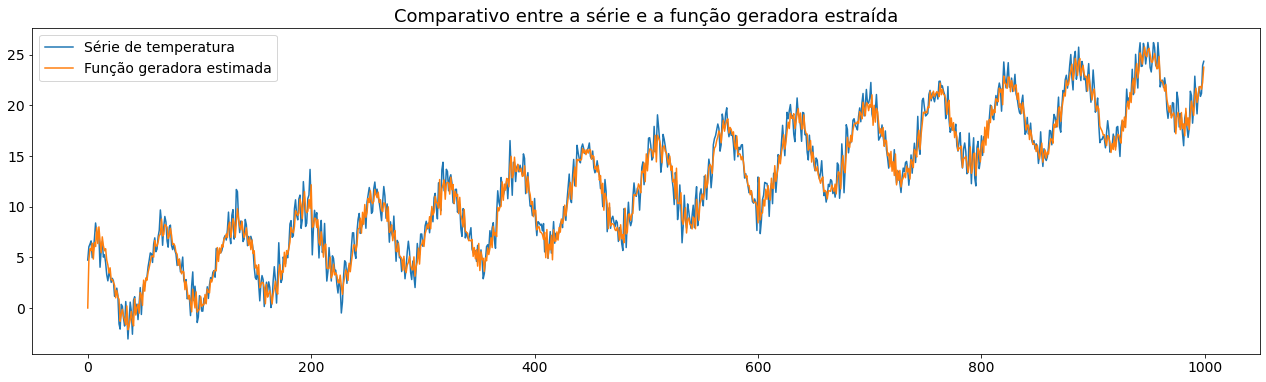

In [68]:
ax = processo_sarima.plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_autosarima.fittedvalues.plot(ax = ax, label="Função geradora estimada", legend= True)

## Modelo SARIMAX

Este modelo leva em consideração variáveis ​​exógenas, ou seja, utiliza dados externos em nossa previsão.

É interessante pensar que todos os fatores exógenos ainda são modelados tecnicamente indiretamente na previsão do modelo histórico. Dito isto, se incluirmos dados externos, o modelo responderá muito mais rapidamente ao seu efeito do que se contarmos com a influência de termos atrasados.


\begin{align}
SARIMAX(p,q,P,Q) &= X_t = \sum_{h=1}^p{\alpha_hx_{t-h}} + \sum_{h=1}^q{\beta_hε_{t-h}} + \color{blue} { \sum_{h=1}^r{\theta_hd_{h_t}}} + \sum_{h=1}^P{\phi_hx_{t-h}} + \sum_{h=1}^Q{\eta_hε_{t-h}} + ε_t 
\end{align}

### Ajustamento

In [69]:
y_aracaju_dif = ( serie_aracaju.tavg - serie_aracaju.tavg.mean() ).dropna().diff()[1:]

In [70]:
resultado_adf(sm.tsa.adfuller(y_aracaju_dif))

Statistics=-14.581, p-valor=0.00000000

**A série é estacionária (rejeitamos H0)**

In [71]:
treino = pd.concat([serie_aracaju.tmin.shift(1), serie_aracaju.tmax.shift(1), serie_aracaju.wspd.shift(1), y_aracaju_dif],axis=1).dropna()

Reescalaremos as variáveis exogenas pelo desvio padrão (standard scaling).

In [72]:
treino.tmin = ((treino.tmin - treino.tmin.mean()) / treino.tmin.std())
treino.tmax = ((treino.tmax - treino.tmax.mean()) / treino.tmax.std())
treino.wspd = ((treino.wspd - treino.wspd.mean()) / treino.wspd.std())

In [73]:
treino.tail()

,tmin,tmax,wspd,tavg
time,,,,
2022-10-27,-0.975630,-2.328063,-0.340626,1.4
2022-10-28,-0.799120,-0.246248,-0.949042,1.2
2022-10-29,-0.210755,-0.246248,0.267790,0.3
2022-10-30,0.377609,-0.246248,0.323100,-0.2
2022-10-31,0.377609,0.100722,0.406066,-0.1


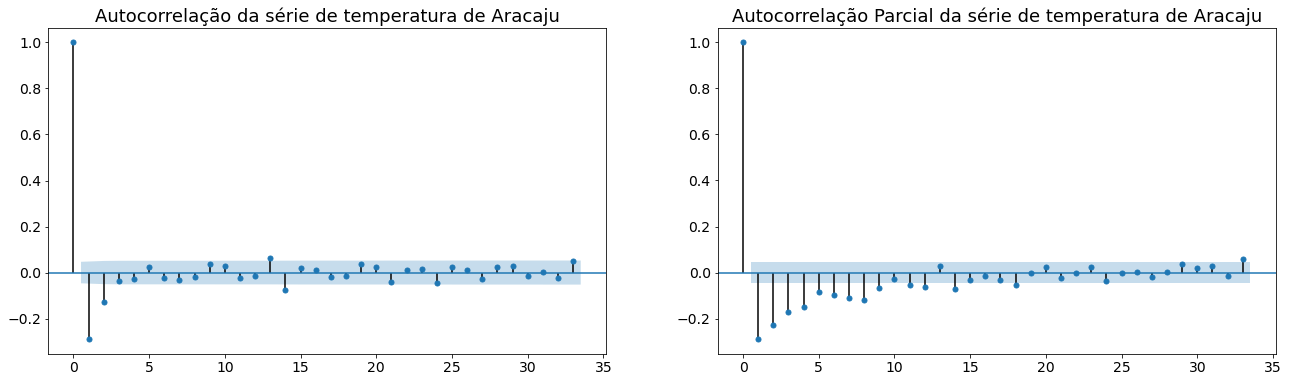

In [74]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(treino.tavg, ax = axs[0], title="Autocorrelação da série de temperatura de Aracaju")
_ = tsa.plot_pacf(treino.tavg, ax = axs[1], title="Autocorrelação Parcial da série de temperatura de Aracaju")

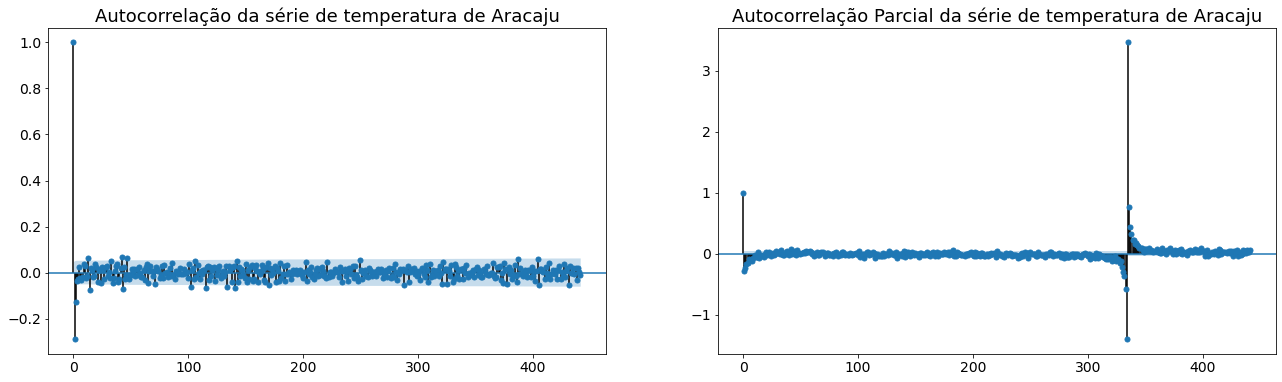

In [75]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(treino.tavg, lags=len(y_aracaju_dif)/4, ax = axs[0], title="Autocorrelação da série de temperatura de Aracaju")
_ = tsa.plot_pacf(treino.tavg, lags=len(y_aracaju_dif)/4,ax = axs[1], title="Autocorrelação Parcial da série de temperatura de Aracaju")

In [76]:
exogenas = treino[["tmin","tmax","wspd"]]
endogena = treino.tavg

In [ ]:
modelo_sarimax = sm.tsa.SARIMAX(endogena, exogenas, order=(8,0,2), seasonal_order=(1,0,0,365)).fit()

In [ ]:
print(modelo_sarimax.summary())

In [ ]:
_ = modelo_sarimax.plot_diagnostics(figsize=(18,12))

In [ ]:
ax = endogena.plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_sarimax.fittedvalues.plot(ax = ax, label="Função geradora estimada", legend= True)

## Exercício

1. Ajuste um modelo SARIMA para a série de temperatura de sua cidade, realize a análise de resíduos e compare a série com o modelo.
2. Ajuste um modelo SARIMAX para a série de temperatura de sua cidade, realize a análise de resíduos e compare a série com o modelo.
3. Utilize o Auto SARIMA para buscar o modelo que mais se ajusta à série de temperatura de sua cidade.
4. Construa uma função de Auto SARIMAX e encontre o modelo que melhor se ajusta à serie de temperatura da sua cidade.